In [6]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import MonthLocator

In [7]:
data = pd.read_csv("../data/history/flightsHistory.csv.gz", parse_dates=["arr_time_utc", "dep_time_utc"], dtype={'holiday': 'string'})

def add_airport_names(df):
    with open('../data/airports.json') as rf:
        airports = json.load(rf)
    airports = pd.json_normalize(airports).set_index('iata_code')
    # arrival airport
    df = pd.merge(df, airports['name'], how='left', left_on='arr_iata', right_index=True)
    df = df.rename(columns={'name': 'arr_airport'})
    df['arr_airport'] = df['arr_iata'] + ": " + df['arr_airport'] + " (" + df['arr_country_code'] + ")"
    # departure airport
    df = pd.merge(df, airports['name'], how='left', left_on='dep_iata', right_index=True)
    df = df.rename(columns={'name': 'dep_airport'})
    df['dep_airport'] = df['dep_iata'] + ": " + df['dep_airport'] + " (" + df['dep_country_code'] + ")"
    return df

def add_airline_names(df):
    with open('../data/airlines.json') as rf:
        airlines = json.load(rf)
    airlines = pd.json_normalize(airlines)
    airlines['iata_code'] = airlines['iata_code'].str.lower()
    airlines = airlines.set_index('iata_code')
    # arrival airport
    df = pd.merge(df, airlines['name'], how='left', left_on='airline_iata', right_index=True)
    df = df.rename(columns={'name': 'airline'})
    df['airline'] = df['airline_iata'] + ": " + df['airline']
    return df

data = add_airport_names(data)
data = add_airline_names(data)
data.info()
data.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 464498 entries, 0 to 370195
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Row                       464498 non-null  int64         
 1   flight_iata               370178 non-null  object        
 2   airline_iata              370178 non-null  object        
 3   dep_time_utc              464498 non-null  datetime64[ns]
 4   dep_actual_utc            462668 non-null  object        
 5   arr_time_utc              464498 non-null  datetime64[ns]
 6   arr_actual_utc            353791 non-null  object        
 7   dep_iata                  464498 non-null  object        
 8   arr_iata                  464498 non-null  object        
 9   dep_country_code          464498 non-null  object        
 10  arr_country_code          464498 non-null  object        
 11  domestic                  464498 non-null  bool          
 12  interna

,Row,flight_iata,airline_iata,dep_time_utc,dep_actual_utc,arr_time_utc,arr_actual_utc,dep_iata,arr_iata,dep_country_code,...,dep_cloud_cover,dep_cloud_cover_low,dep_cloud_cover_mid,dep_cloud_cover_high,dep_wind_speed_10m,dep_wind_speed_100m,dep_wind_gusts_10m,arr_airport,dep_airport,airline
0,0,vn30,vn,2022-10-17 14:35:00,2022-10-17 14:54:00,2022-10-18 07:55:00,2022-10-18 06:59:00,FRA,SGN,DE,...,82.199997,53.0,9.0,97.0,6.297428,13.70839,18.00,SGN: Tan Son Nhat International Airport (VN),FRA: Frankfurt Airport (DE),vn: Vietnam Airlines
1,1,qh74,qh,2022-10-17 20:10:00,2022-10-17 20:31:00,2022-10-18 12:50:00,2022-10-18 12:02:00,FRA,HAN,DE,...,78.000000,0.0,93.0,74.0,6.638072,13.55150,11.52,HAN: Noi Bai International Airport (VN),FRA: Frankfurt Airport (DE),qh: Bamboo Airways


<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 2023-11-26 to 2023-07-30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   valid    405 non-null    int64
 1   invalid  405 non-null    int64
dtypes: int64(2)
memory usage: 9.5+ KB
            valid  invalid
arr_date                  
2023-11-26     76      217
2022-12-20    420     1385
2023-01-18    505     1696
2022-12-19    517     1355
2023-11-20    593     1257
...           ...      ...
2023-06-11   1130     1089
2023-06-25   1131     1095
2023-07-23   1132     1141
2023-07-09   1138     1137
2023-07-30   1143     1149

[405 rows x 2 columns]


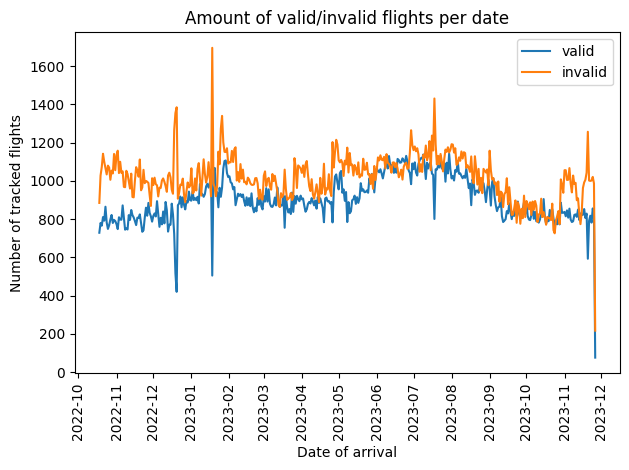

In [4]:
def group_by_date(df):
    df['arr_date'] = pd.to_datetime(df['arr_time_utc']).dt.date
    df = df.groupby(['arr_date']).size().sort_values(ascending=True).reset_index(name='counts')
    df.set_index('arr_date', inplace=True)
    return df


def analyze_records_by_day():
    valid_flights = pd.read_csv("../extract/data/history/flightsHistory.csv")
    invalid_flights = pd.read_csv("../extract/data/history/flightsHistory_invalid.csv")
    valid_flights = group_by_date(valid_flights).rename(columns={"counts": "valid"})
    invalid_flights = group_by_date(invalid_flights).rename(columns={"counts": "invalid"})
    flights = pd.merge(valid_flights, invalid_flights, how='outer', on='arr_date')
    flights.info()
    print(flights.head(500))
    ax = flights.plot()
    ax.xaxis.set_major_locator(MonthLocator())
    plt.xticks(rotation=90)
    plt.title("Amount of valid/invalid flights per date")
    plt.ylabel("Number of tracked flights")
    plt.xlabel("Date of arrival")
    plt.tight_layout()
    plt.show()

analyze_records_by_day()

   codeshared  missing_information      valid  duplicate_iata_dep_time
0   54.682202            22.584767  20.233965                 2.499065


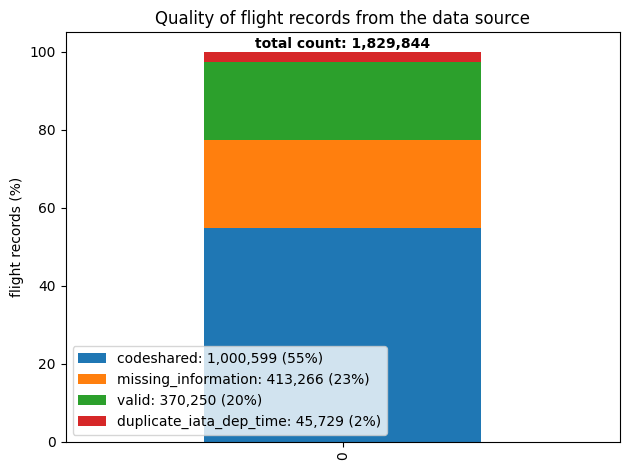

In [45]:
def get_score(delays):
    n_flights = len(delays)
    avg_delay = delays[delays > 0].mean()
    delay_percentage = np.sum(delays > 0) / n_flights
    return avg_delay * delay_percentage

def plot_delay_ratios(group_col, score_function=get_score, filter_strategy=None):
    # Filter out samples where it's airline iata appears 1000 times or more
    num_samples_thresh = 500
    group_counts = data[group_col].value_counts()
    data_fltd = data[data[group_col].isin(group_counts[group_counts >= num_samples_thresh].index)].copy()
    result = data_fltd.groupby([data_fltd['dep_time_utc'].dt.to_period('M'), group_col]).agg(
        delayed_percentage=('delayed', lambda x: np.sum(x > 0) / len(x)), 
        total_flights=('flight_iata', 'count'),
        score=('delayed', score_function))
    result = result.sort_values(by='score', ascending=False)
    result.reset_index(inplace=True)
    
    if filter_strategy:
        interesting_groups = (result.groupby(group_col)
                                    .agg(score_std=('score', filter_strategy[0]))
                                    .sort_values(by='score_std', ascending=False)
                                    .reset_index()[:filter_strategy[1]])
        result = result[result[group_col].isin(interesting_groups[group_col])]
    
    pivot = result.pivot(index='dep_time_utc', columns=group_col, values='score')
    pivot.plot(kind='line')
    plt.legend()
    plt.title(f"Monthly delay scores grouped by {group_col}")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
    plt.ylabel('delay score')
    plt.show()

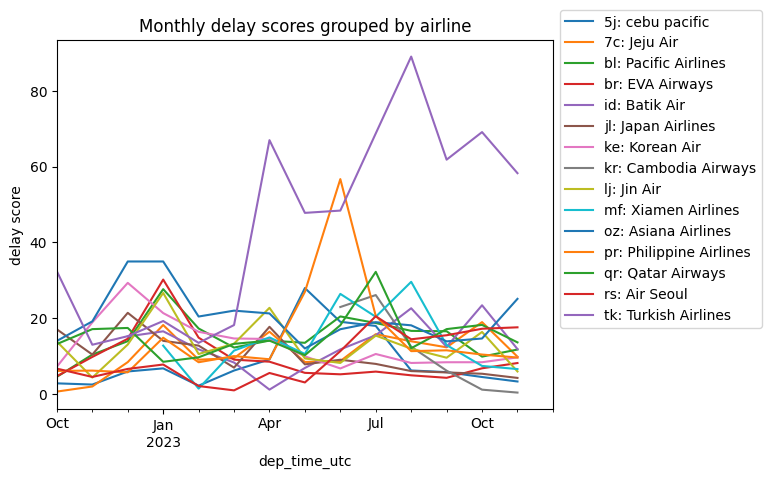

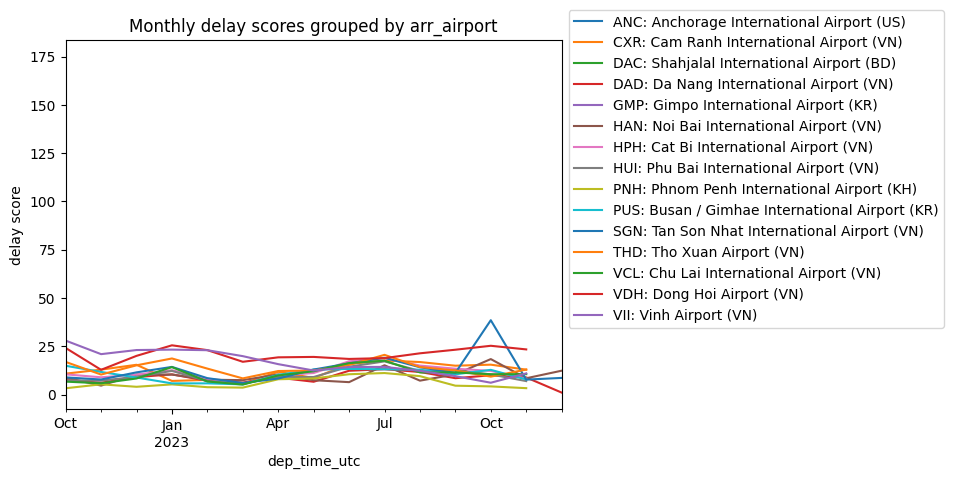

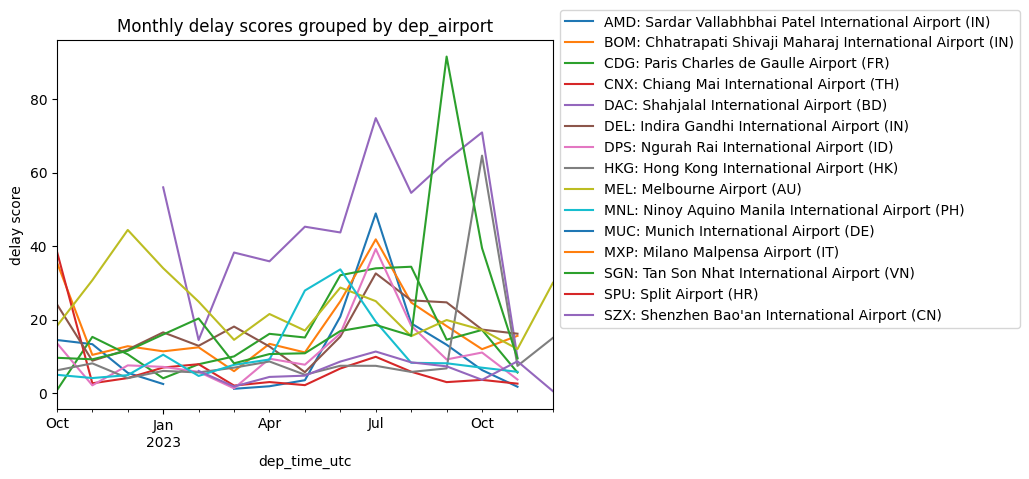

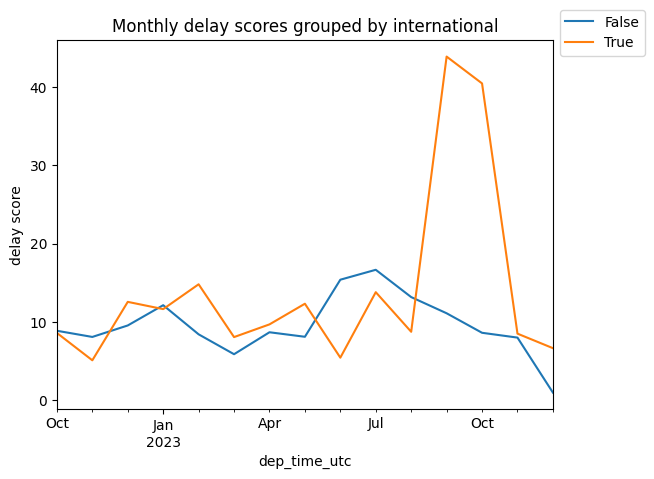

In [47]:
# select a group if the score mean very high or else if a high std deviation promises some interesting peeks
group_ranking_func = lambda score: 1000 if score.mean() > 15 else score.std()

plot_delay_ratios('airline', filter_strategy=(group_ranking_func, 15))
plot_delay_ratios('arr_airport', filter_strategy=(group_ranking_func, 15))
plot_delay_ratios('dep_airport', filter_strategy=(group_ranking_func, 15))
plot_delay_ratios('international')

## Airlines
The above plots show that some few airlines stand out in terms of delay, especially Turkish Airlines since april 2023. All top delay airlines are not Vietnamese which only operate for international flights.  
We can also observe peeks January (that's the time of (lunar) new year 2023), April and July.

## Airports
Arrival airports don't seem to have a remarkable influence on the arrival delay. 
Probably because it's more the responsibilty of the departure airport to get the aircraft into the air in time.  

So said, departure airports result in varying delay scores.
Most of them are not in Vietnam, so again international flights.

## International/Domestic flights
Viewing directly onto international flights shows that they are severely more delayed than domestic flights, but only in september and october.
This is probably the most popular time for traveling to Vietnam, so there are many international flights having more delay potential.

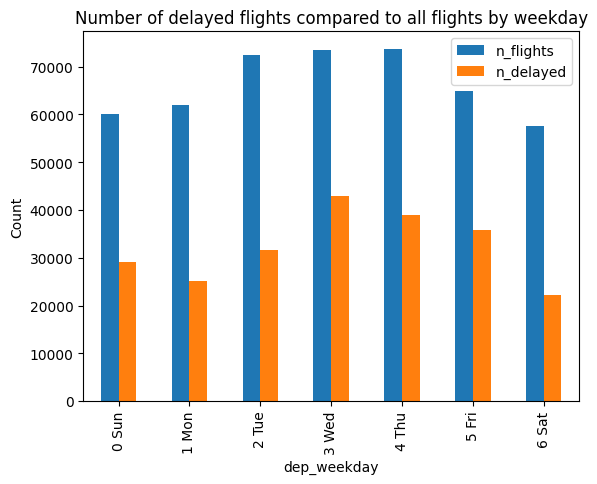

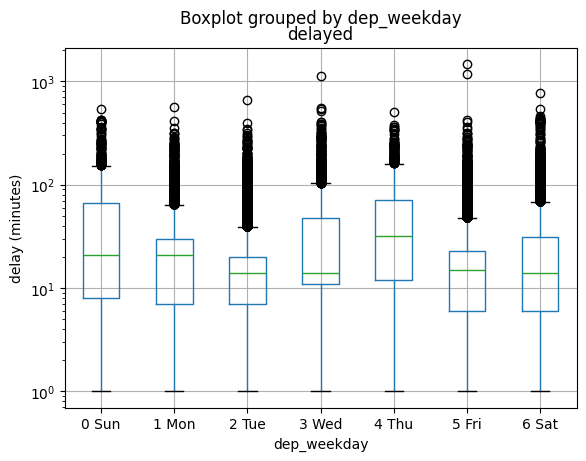

In [57]:
data["dep_weekday"] = data["dep_time_utc"].dt.strftime("%w %a")
grouped_data = data.groupby('dep_weekday').agg(n_flights=('delayed', 'count'), 
                                               n_delayed=('delayed', lambda x: np.sum(x > 0)),
                                               avg_delay_all=('delayed', 'mean'),
                                               avg_delay_delayed=('delayed', lambda x: x[x > 0].mean()),
                                               score=('delayed', get_score)).sort_index()
grouped_data[['n_flights', 'n_delayed']].plot.bar(ylabel='Count')
plt.title('Number of delayed flights compared to all flights by weekday')
plt.show()
data[data['delayed'] > 0].boxplot(by='dep_weekday', column=['delayed'], ylabel='delay (minutes)')
plt.yscale('log')
plt.show()